## 5.3エッジ強調

### この節について

この節ではエッジ強調について解説します。

この節のの内容はColabノートブックとして公開してあります。ノートブックを見るには[目次ページ](https://colab.research.google.com/github/moizumi99/camera_raw_processing/blob/master/camera_raw_toc.ipynb)から参照するか、以下のリンクを使ってアクセスしてください。

https://colab.research.google.com/github/moizumi99/camera_raw_processing/blob/master/camera_raw_chapter_5_3.ipynb

### 準備

まずライブラリーのインストールと、モジュールのインポート、画像の読み込みを行います。今回もラズベリーパイで撮影したチャート画像を使用します。
内容については各節を参照ください。

In [1]:
# rawpyとimageioのインストール
!pip install rawpy;
!pip install imageio;

# rawpy, imageio, numpuy, pyplot, imshowのインポート
import rawpy, imageio
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

# 前節までに作成したモジュールのダウンロードとインポート
!if [ ! -f raw_process.py ]; wget https://github.com/moizumi99/camera_raw_processing/raw/master/raw_process.py; fi
from raw_process import simple_demosaic, white_balance, black_level_correction, gamma_correction
from raw_process import demosaic, defect_correction, color_correction_matrix, lens_shading_correction
from raw_process import noise_filter

# 日本語フォントの設定
!apt -y install fonts-ipafont-gothic
plt.rcParams['font.family'] = 'IPAPGothic'
# もし日本語が文字化けしている場合`! rm /content/.cache/matplotlib/fontList.json`を実行して、
# Runtime->Restart Runtimeで再実行

# 画像をダウンロードします。
!if [ ! -f chart.jpg ]; then wget https://github.com/moizumi99/camera_raw_processing/raw/master/chart.jpg; fi

# 自分で撮影した画像を使用する場合は以下のコメントを取り除きアップロードします。
# from google.colab import files
# uploaded = files.upload()

# RAWファイルの名前。
# アップロードしたファイルを使う場合はその名前に変更。
raw_file  = "chart.jpg"
raw = rawpy.imread(raw_file)
raw_array = raw.raw_image
h, w = raw_array.shape

You are using pip version 19.0.1, however version 19.0.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
You are using pip version 19.0.1, however version 19.0.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
/bin/sh: 1: Syntax error: "fi" unexpected (expecting "then")
E: Could not open lock file /var/lib/dpkg/lock-frontend - open (13: Permission denied)
E: Unable to acquire the dpkg frontend lock (/var/lib/dpkg/lock-frontend), are you root?


### 画像の解像感

前回までに作成した画像の細部をもう一度よく見てみましょう。

In [2]:
blc_raw = black_level_correction(raw_array, raw.black_level_per_channel, raw.raw_pattern)
lsc = [np.array([6.07106808e-07, 9.60556906e-01]), 
       np.array([6.32044369e-07, 9.70694361e-01]), 
       np.array([6.28455183e-07, 9.72493898e-01]), 
       np.array([9.58743579e-07, 9.29427169e-01])]
lsc_raw = lens_shading_correction(blc_raw, lsc)
dpc_raw = defect_correction(lsc_raw, 16)
wb_raw = white_balance(dpc_raw, raw.camera_whitebalance, raw.raw_colors)
dms_img = demosaic(wb_raw, raw.raw_colors)
noise_model=(0.29300604909937544, 10.754229129481296)
nfl3_img = noise_filter(dms_img, noise_model)
color_matrix = np.array([6022,-2314,394,-936,4728,310,300,-4324,8126])/4096
ccm_img = color_correction_matrix(nfl3_img, color_matrix)
white_level = 1024
gmm_img = gamma_correction(ccm_img / white_level, 2.2)

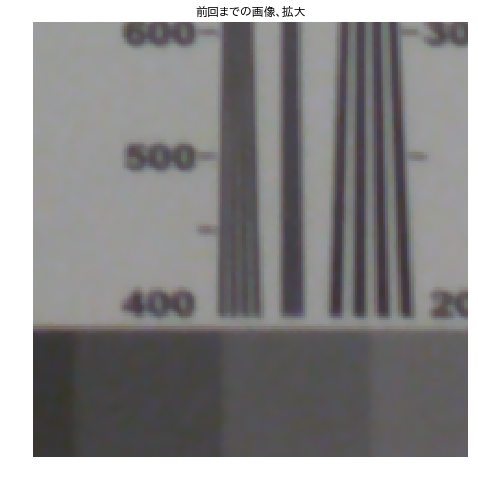

In [3]:
# 最終画像表示
plt.figure(figsize=(8, 8))
plt.imshow(gmm_img[1500:1700, 1650:1850, :])
plt.axis('off')
plt.title(u"前回までの画像、拡大")
plt.show()

どことなくぼやっとしていて、コントラストも少し低いようです。

エッジ強調を使って改善してみましょう。

今回エッジ強調に使うのはアナログの時代から使われてきたアンシャープマスキングという手法です。
これは、入力画像をぼやけさせた画像をまず作り、そのぼやけさせた画像を元の画素から引いてやることで行います。
ぼやけさせた画像は入力画像より暗くしておく必用があります。

式で表すとこのようになります。入力画像$g \left( x, y \right)$に対し、ぼやけさせた画像を$f \left( x, y \right)$とすると、出力画像は

$$
h \left( x, y \right) = g \left( x, y \right) - a f \left( x, y \right)
$$

となります。このままでは暗くなってしまうので、明るさを調整すると、こうなります。

$$
h \left( x, y \right) = g \left( x, y \right) + a \left( g \left( x, y \right) -  f \left( x, y \right) \right)
$$

後半の部分はハイパスフィルターになっており、結局元の画像に高周波成分を足し合わせるのと同じ処理になっていることがわかります。

では実際に処理してみましょう。

エッジ強調は輝度成分に対して行うことが多いので、まずRGB画像から輝度成分を分離しましょう。
輝度と色の成分を含む色空間としては、カメラやJPEGでは通常YCbCr空間が使われます。今回もYCbCrを使ってみましょう。
YCbCrというのは輝度信号(Y)と２つの色差信号(Cb, Cr)でフルカラーを表す方式です。

sRGBからJPEGで使われるYCbCr空間への変換マトリクスはこのようになっています。

$$
\left(
\begin{array}{rr}
0.299 &0.587 &0.144 \\\
-0.168736 &-0.331264 &0.5 \\\ 
0.5 &-0.418688 &-0.081312\\\
\end{array}
\right)
$$

この他に通常CbとCr信号には+0.5のオフセットがのりますが、今回は省きました。

ではRGB信号をYCbCrに分解してみます。

In [5]:
rgb2ycbcr = np.array([[0.299, 0.587, 0.144], [-0.168736, -0.331264, 0.5], [0.5, -0.418688, -0.081312]])

# 色空間の変換
ycb_img = np.zeros_like(gmm_img)
for c in (0, 1, 2):
    ycb_img[:, :, c] = rgb2ycbcr[c, 0] * gmm_img[:, :, 0] + \
                           rgb2ycbcr[c, 1] * gmm_img[:, :, 1] + \
                           rgb2ycbcr[c, 2] * gmm_img[:, :, 2]

このうち輝度成分を取り出して確認してみましょう。

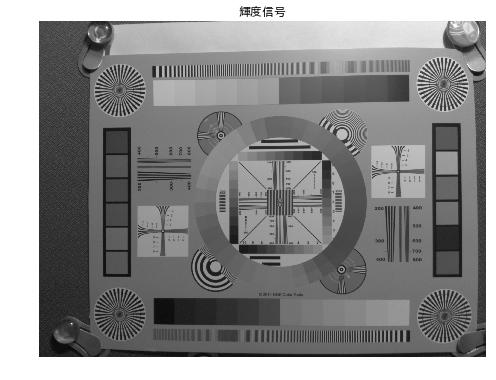

In [6]:
luma = ycb_img[:, :, 0]
plt.figure(figsize=(8, 8))
plt.imshow(luma, cmap='gray')
plt.axis('off')
plt.title('輝度信号')
plt.show()

うまく変換できているようです。

それではアンシャープマスクをかけてみましょう。

まずはぼやけた画像を作成します。このためにscipyのgaussian_filterという機能を使います。

In [7]:
import scipy
# scipyのgaussian_filterによってガウシアンフィルターをかける。
blurred = scipy.ndimage.gaussian_filter(luma, sigma = 2)

どんな画像になったか見てみましょう。

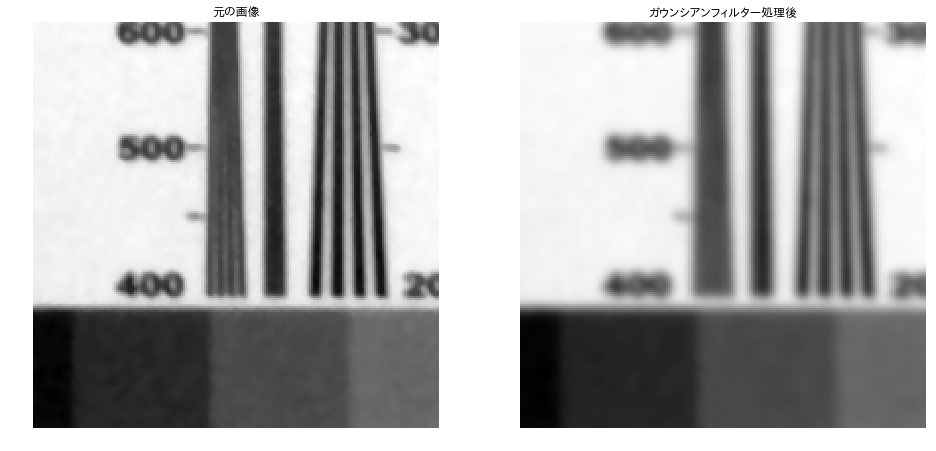

In [8]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.imshow(luma[1500:1700, 1650:1850], cmap='gray')
plt.axis('off')
plt.title('元の画像')
plt.subplot(1, 2, 2)
plt.imshow(blurred[1500:1700, 1650:1850], cmap='gray')
plt.axis('off')
plt.title('ガウンシアンフィルター処理後')
plt.show()

ガウシアンフィルターをかけた画像はかなりぼやけているのがわかります。

元の画像からフィルターをかけた画像を引き明るさを調整します。

In [9]:
# アンシャープマスクの強度。
coef = 0.25
unsharp = luma + coef * (luma - blurred)

表示して確認してみましょう。

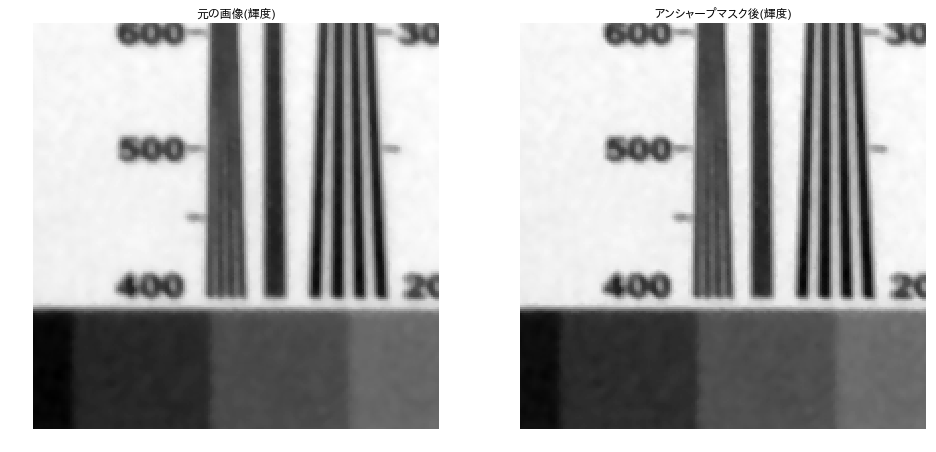

In [10]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.imshow(luma[1500:1700, 1650:1850], cmap='gray')
plt.axis('off')
plt.title('元の画像(輝度)')
plt.subplot(1, 2, 2)
plt.imshow(unsharp[1500:1700, 1650:1850], cmap='gray')
plt.axis('off')
plt.title('アンシャープマスク後(輝度)')
plt.show()

解像感が上がっているのが確認できました。

次にカラー画像に戻します。

In [11]:
# YCbCrからRGBへの変換の逆行列を求める。
ycbcr2rgb = np.linalg.inv(rgb2ycbcr)
shp_img = ycb_img.copy()
# YCbCr画像の輝度成分をエッジ強調したもので置き換える
shp_img[:, :, 0] = unsharp
out_img = np.zeros_like(shp_img)
# RGBに変換。
for c in (0, 1, 2):
    out_img[:, :, c] = ycbcr2rgb[c, 0] * shp_img[:, :, 0] + \
                           ycbcr2rgb[c, 1] * shp_img[:, :, 1] + \
                           ycbcr2rgb[c, 2] * shp_img[:, :, 2]

カラーでも画像を確認しておきます。

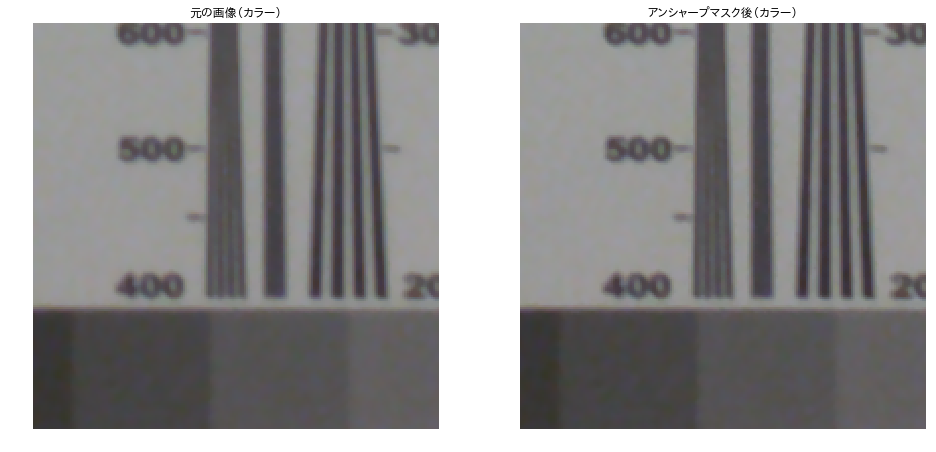

In [12]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.imshow(gmm_img[1500:1700, 1650:1850, :])
plt.axis('off')
plt.title('元の画像（カラー）')
plt.subplot(1, 2, 2)
plt.imshow(out_img[1500:1700, 1650:1850, :])
plt.axis('off')
plt.title('アンシャープマスク後（カラー）')
plt.show()

カラー画像でも細部がはっきりしたのが確認できました

### モジュールへの追加

エッジ強調もモジュールとして追加しておきます。

In [13]:
# RGB to YCbCr 変換マトリクス
RGB_TO_YCBCR = np.array([[0.299, 0.587, 0.144],
                         [-0.168736, -0.331264, 0.5],
                         [0.5, -0.418688, -0.081312]])

def apply_matrix(rgb_img, matrix):
    """
    画像に3x3の色変換行列をかける。

    Parameters
    ----------
    rgb_img: numpy 3d array
        入力RGB画像
    matrix: float 2d array
        3x3の色空間変換マトリクス

    Returns
    -------
    out_img: numpy array
        色空間変換後の画像
    """
    out_img = np.zeros_like(rgb_img)
    for c in (0, 1, 2):
        out_img[:, :, c] = matrix[c, 0] * rgb_img[:, :, 0] + \
                           matrix[c, 1] * rgb_img[:, :, 1] + \
                           matrix[c, 2] * rgb_img[:, :, 2]
    return out_img

def edge_enhancement(rgb_img, sigma=2, coef=0.25):
    """
    アンシャープマスクによるエッジ強調。

    Parameters
    ----------
    rgb_img: numpy 3d array
        入力RGB画像
    sigma: float
        ガウシアンフィルターのsigma
    coef: float
        アンシャープマスクの強度。

    Returns
    -------
    out_img: numpy array
        エッジ強調後の画像
    """
    
    # 色空間をRGBからYCbCrに変換。
    ycr_img = apply_matrix(rgb_img, RGB_TO_YCBCR)
    # 輝度成分のみとりだしガウシアンフィルターでぼかす。
    luma = ycr_img[:, :, 0]
    unsharpen = scipy.ndimage.gaussian_filter(luma, sigma=sigma)
    # アンシャープマスク処理。
    sharpen = luma + coef * (luma - unsharpen)
    ycr_img[:, :, 0] = sharpen
    
    #　逆行列を求め、YCbCrからRGBへの変換行列を求める。
    ycbcr2rgb = np.linalg.inv(RGB_TO_YCBCR)
    # RGB画像を生成して調整。
    shp_img = apply_matrix(ycr_img, ycbcr2rgb)
    shp_img[shp_img < 0] = 0
    shp_img[shp_img > 1] = 1
    return shp_img

全処理を行って動作を確認します。

In [14]:
blc_raw = black_level_correction(raw_array, raw.black_level_per_channel, raw.raw_pattern)
lsc = [np.array([6.07106808e-07, 9.60556906e-01]), 
       np.array([6.32044369e-07, 9.70694361e-01]), 
       np.array([6.28455183e-07, 9.72493898e-01]), 
       np.array([9.58743579e-07, 9.29427169e-01])]
lsc_raw = lens_shading_correction(blc_raw, lsc)
dpc_raw = defect_correction(lsc_raw, 16)
wb_raw = white_balance(dpc_raw, raw.camera_whitebalance, raw.raw_colors)
dms_img = demosaic(wb_raw, raw.raw_colors)
noise_model=(0.29300604909937544, 10.754229129481296)
nfl3_img = noise_filter(dms_img, noise_model)
color_matrix = np.array([6022,-2314,394,-936,4728,310,300,-4324,8126])/4096
ccm_img = color_correction_matrix(nfl3_img, color_matrix)
white_level = 1024
gmm_img = gamma_correction(ccm_img / white_level, 2.2)
shp_img = edge_enhancement(gmm_img, 2, 0.25)

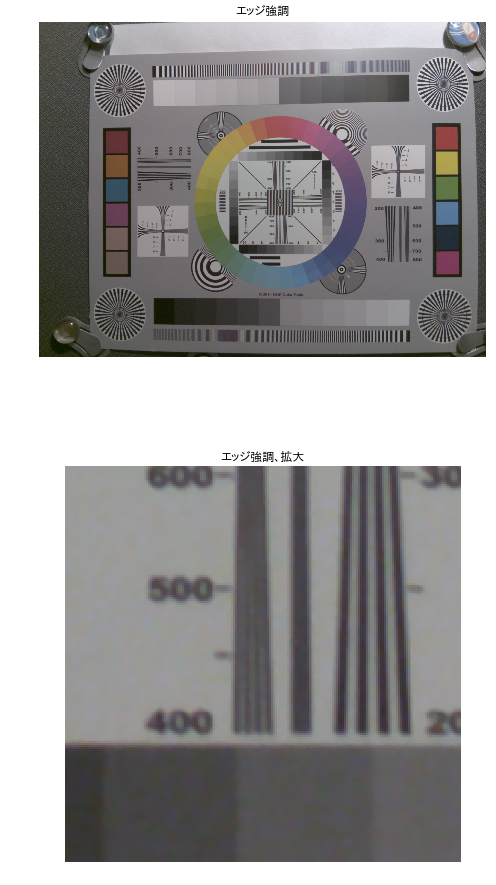

In [15]:
# 最終画像表示
plt.figure(figsize=(8, 16))
plt.subplot(2, 1, 1)
plt.imshow(shp_img)
plt.axis('off')
plt.title(u"エッジ強調")
plt.subplot(2, 1, 2)
plt.imshow(shp_img[1500:1700, 1650:1850, :])
plt.axis('off')
plt.title(u"エッジ強調、拡大")
plt.show()

うまく処理できているようです。

### まとめ

今回は古典的なアンシャープマスキングによるエッジ強調を行いました。
昔から知られている処理ですが、現代のエッジ強調アルゴリズムにも通じる部分の多い重要なアルゴリズムです。

次は[トーンカーブ補正](https://colab.research.google.com/github/moizumi99/camera_raw_processing/blob/master/camera_raw_chapter_5_4.ipynb)をあつかいます。